# Time series with structural breaks

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot, print_causal_directions, print_dagc
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
B0_regime1 = [[0.0, 0.0, 0.0],
              [2.0, 0.0, 0.0],
              [-1.0, 0.5,0.0]]

B0_regime2 = [[0.0, 0.0, 0.0],
              [-1.0, 0.0, 0.0],
              [5.0, 0.0,0.0]]

B1_regime1 = [[0.7, 0.0, 0.0],
              [0.2, -0.6, 0.0],
              [0.1, 0.0,0.1]]

B1_regime2 = [[0.0, 0.0, 0.0],
              [0.2, 0.2, 0.0],
              [0.5, 0.0,0.1]]

causal_order = [0, 1, 2]

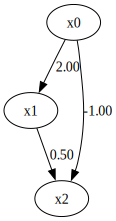

In [3]:
# Contemporaneous effects
make_dot(B0_regime1)

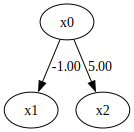

In [4]:
# Contemporaneous effects
make_dot(B0_regime2)

Text(0.5, 1.0, 'Generated Time Series Data with Switching Regime')

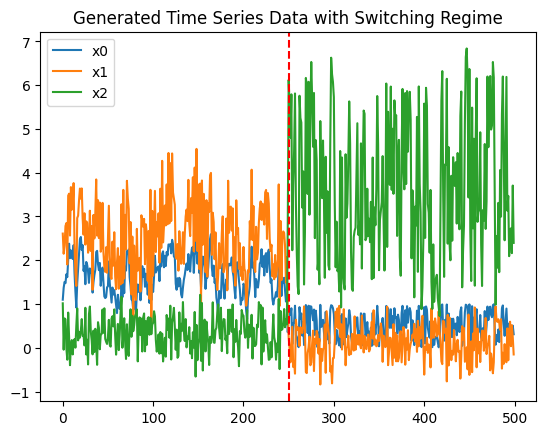

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Sample size
np.random.seed(0)
n_features = len(causal_order)
sample_size = 500
switch_point = 250  # Midpoint switch

# Coefficients for two different regimes
B0_regime1 = np.array(B0_regime1)
B0_regime2 = np.array(B0_regime2)
B1_regime1 = np.array(B1_regime1)
B1_regime2 = np.array(B1_regime2)

# Initialize the data matrix with zeros (considering t and t-1)
data = np.zeros((sample_size + 1, n_features))  # +1 to accommodate initial values at t=-1

# Data matrix to accommodate initial values at t=-1
for i in range(n_features):
    data[:, i] += np.random.uniform(size=sample_size + 1)

# Generate data according to VARLiNGAM model with switching regimes
for t in range(1, sample_size + 1):
    if t < switch_point:
        for var in causal_order:
            data[t, var] += np.dot(B0_regime1[var, :], data[t, :]) + np.dot(B1_regime1[var, :], data[t-1, :])
    else:
        for var in causal_order:
            data[t, var] += np.dot(B0_regime2[var, :], data[t, :]) + np.dot(B1_regime2[var, :], data[t-1, :])

# Drop the initial row used for t=-1 values
data = data[1:, :]

# Convert to DataFrame for easier handling
X = pd.DataFrame(data, columns=[f"x{i}" for i in range(n_features)])

# Plotting
for i in range(X.shape[1]):
    plt.plot(X.index, X.iloc[:, i], label=f'x{i}')
plt.legend()
plt.axvline(x=switch_point, color='r', linestyle='--', label='Switch Point')
plt.title('Generated Time Series Data with Switching Regime')

## Fitting one model to all the data

Text(0.5, 1.0, 'Residuals with Switching Regime')

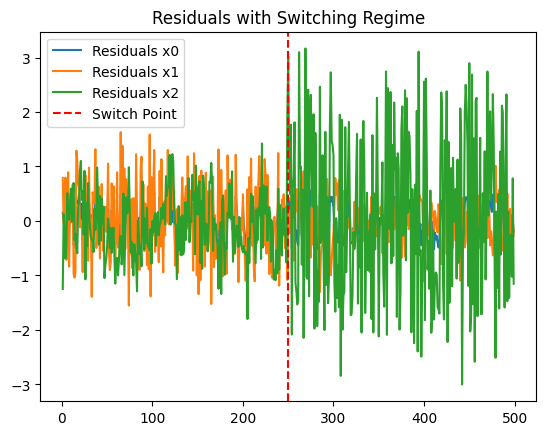

In [6]:
from statsmodels.tsa.vector_ar.var_model import VAR

# Fit one VAR model to each regime
var_model = VAR(X)
var_results = var_model.fit(1)
residuals = var_results.resid

# Plotting residuals
for i in range(3):
    plt.plot(residuals.iloc[:, i], label=f'Residuals x{i}')
plt.axvline(x=switch_point, color='r', linestyle='--', label='Switch Point')
plt.legend()
plt.title('Residuals with Switching Regime')

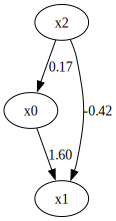

In [7]:
import lingam
from lingam.utils import make_dot

# Apply LiNGAM to all the data
lingam_model = lingam.DirectLiNGAM()
lingam_model.fit(residuals)
make_dot(lingam_model.adjacency_matrix_)  # B0

## Fitting two separate models

Text(0.5, 1.0, 'Residuals with Switching Regime')

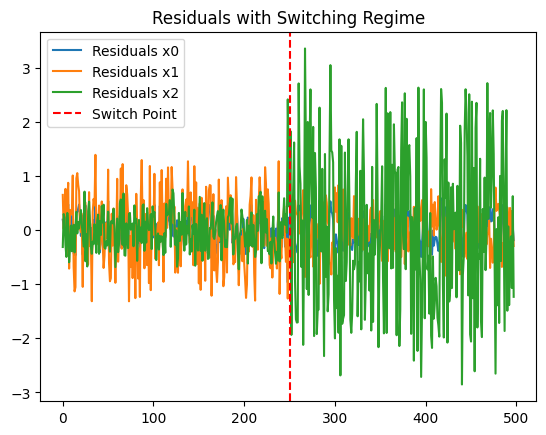

In [8]:
# Split the data into two regimes
x_regime1 = X.iloc[:switch_point, :]
x_regime2 = X.iloc[switch_point:, :]

# Fit VAR model to each regime
var_model1 = VAR(x_regime1)
var_results1 = var_model1.fit(1)  # VAR(1) for simplicity
residuals_regime1 = var_results1.resid

var_model2 = VAR(x_regime2)
var_results2 = var_model2.fit(1)  # VAR(1) for simplicity
residuals_regime2 = var_results2.resid

# Plotting residuals
combined_residuals = np.vstack([residuals_regime1, residuals_regime2])
for i in range(3):
    plt.plot(combined_residuals[:, i], label=f'Residuals x{i}')
plt.axvline(x=switch_point, color='r', linestyle='--', label='Switch Point')
plt.legend()
plt.title('Residuals with Switching Regime')

In [9]:
# Apply LiNGAM for each regime
lingam_model1 = lingam.DirectLiNGAM()
lingam_model1.fit(residuals_regime1)

lingam_model2 = lingam.DirectLiNGAM()
lingam_model2.fit(residuals_regime2)

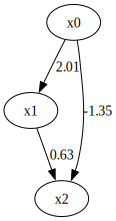

In [10]:
make_dot(lingam_model1.adjacency_matrix_)  # B0 regime 1

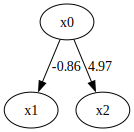

In [11]:
make_dot(lingam_model2.adjacency_matrix_) # B0 regime 2